In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!pip install -q datasets flash_attn timm einops bitsandbytes accelerate

In [4]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import random, torch
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
import requests
import copy
%matplotlib inline

2024-08-13 18:43:07.787972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 18:43:07.788077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 18:43:07.920727: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
model_id = 'microsoft/Florence-2-large'

## HF Login

## Load model

In [6]:
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True,
                                             device_map='cuda')
print(model)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 256, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              (fn): De

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
def run_example(task_prompt, image):
    inputs = processor(text=task_prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [8]:
from PIL import Image

In [12]:
local_image_path = "/kaggle/input/images/radiolog report.jpg"

In [13]:
image = Image.open(local_image_path)

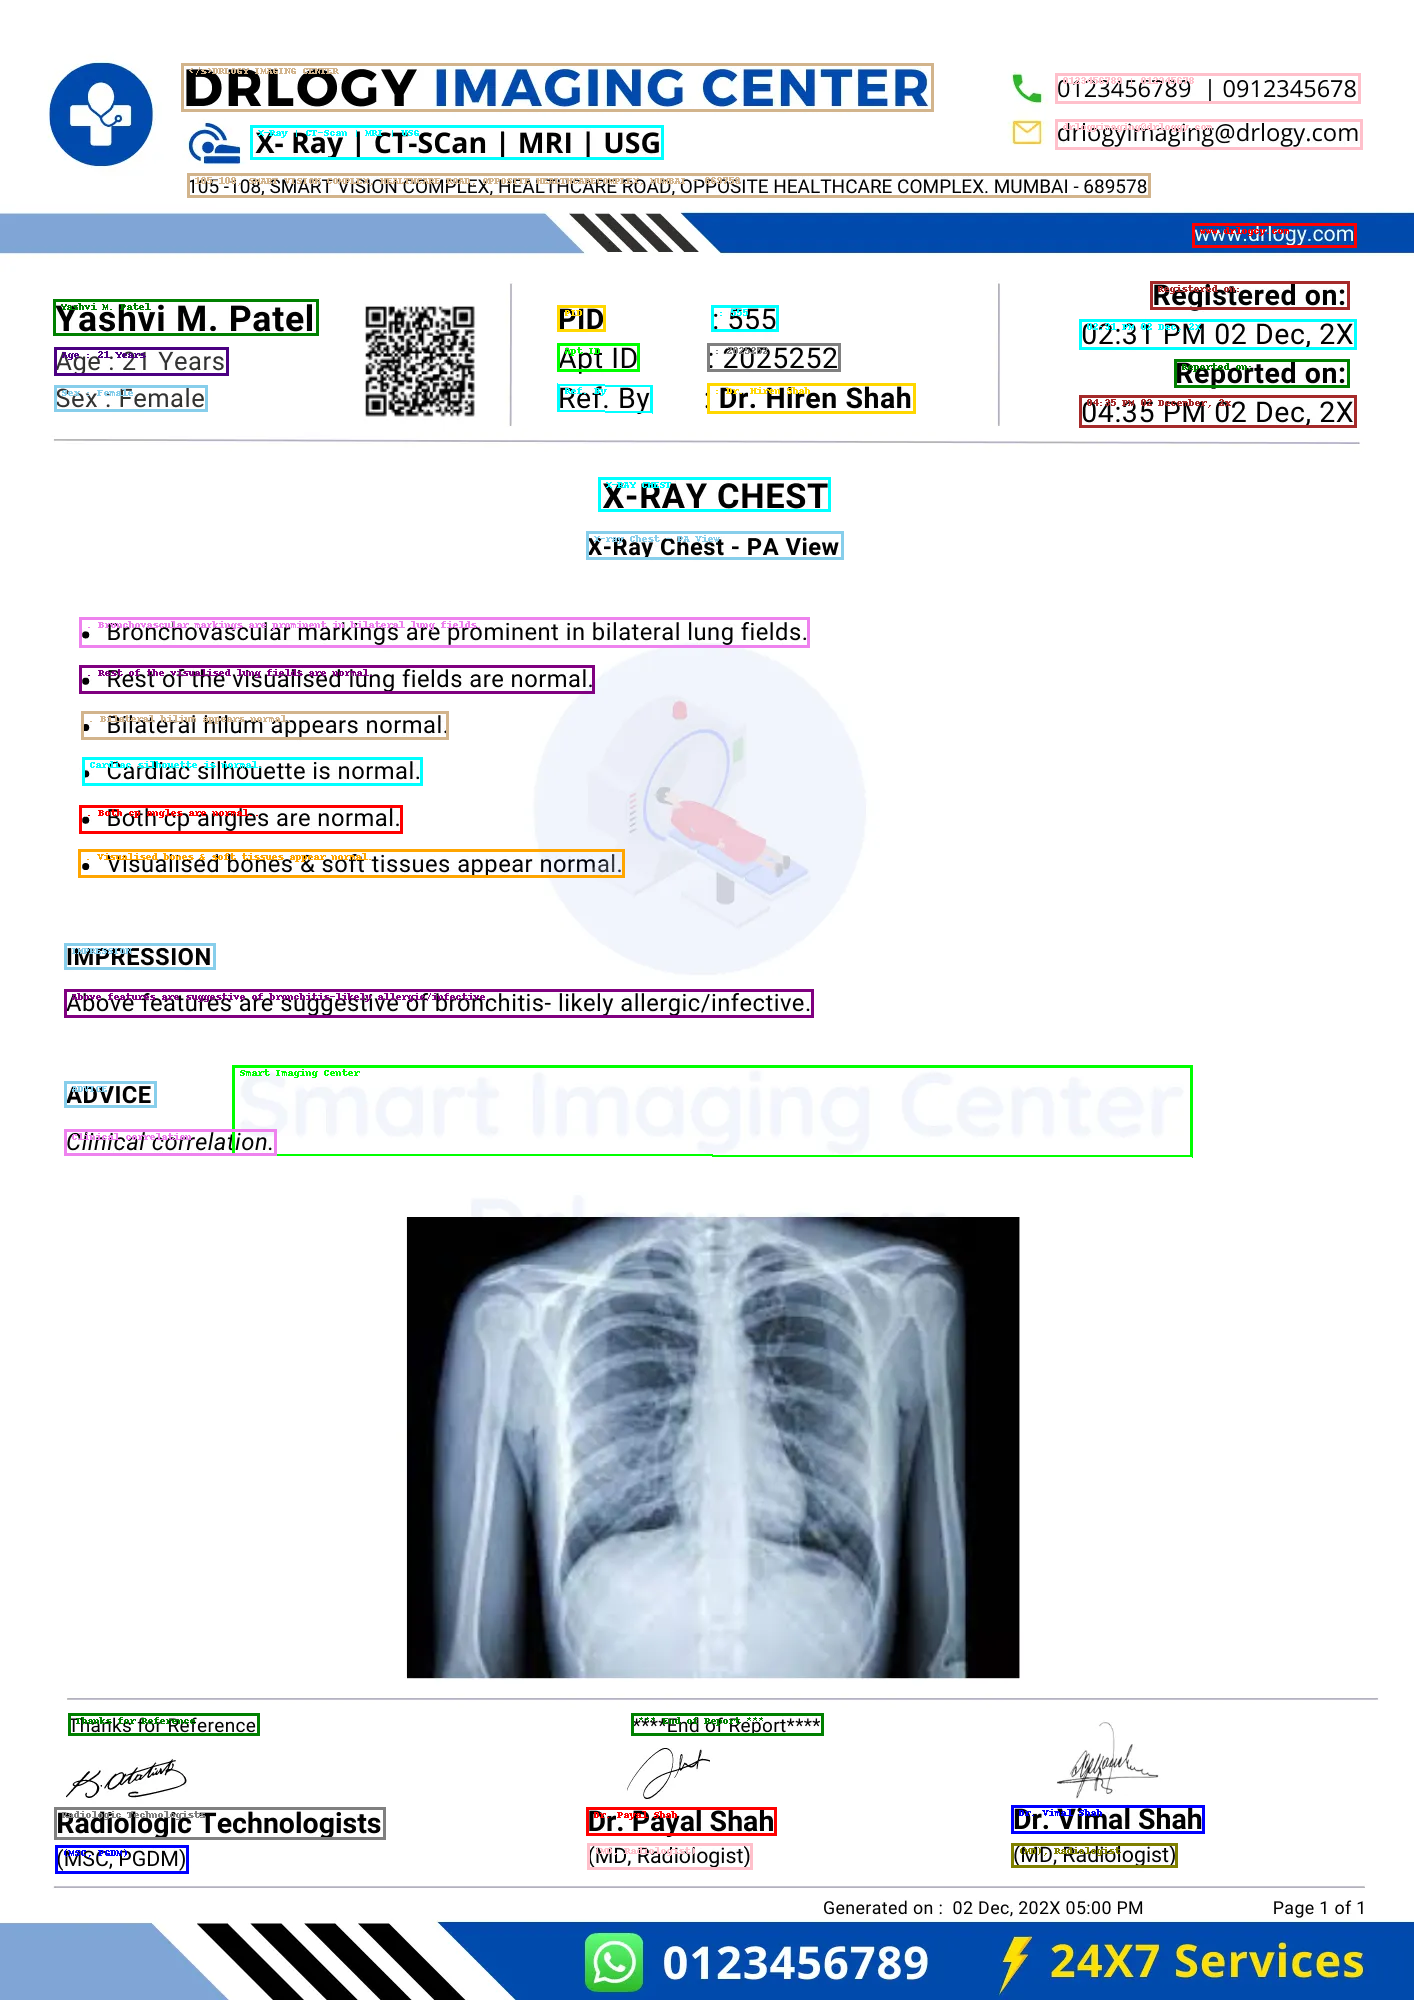

In [14]:
image

## Caption Task

In [15]:
task_prompt = '<CAPTION>'
run_example(task_prompt,image)

{'<CAPTION>': 'A screenshot of the Dr. Ray Imaging Center website.'}

## Detailed Caption

In [16]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt, image)

{'<DETAILED_CAPTION>': "The image shows a poster with an x-ray image of a man's chest, along with text, a barcode, and a QR code. The poster is likely advertising a radiology imaging center in Mumbai, as indicated by the text."}

#### To process the location tokens and render them on the image, the following method will be called to plot bounding boxes.

{'<OD>': {'bboxes': [[429.1490173339844, 1211.0, 973.5390014648438, 1685.0]], 'labels': ['person']}}


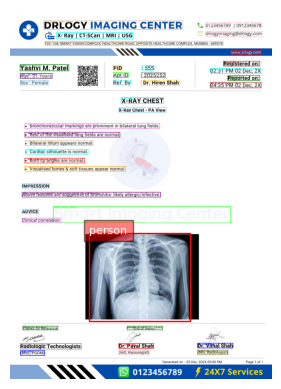

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

task_prompt = '<OD>'
results = run_example(task_prompt,image)
print(results)
plot_bbox(image, results['<OD>'])

## OCR

This function processes Florence-2's output to get the location tokens, used them to draw bounding boxes, and then writes the label corresponding to the bounding boxes, i.e., the text recognized through OCR.

In [18]:
def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    display(image)

In [19]:
task_prompt = '<OCR>'
run_example(task_prompt,image)

{'<OCR>': 'DRLOGY IMAGING CENTER0123456789 | 012345678X-Ray | CT-Scan | MRI | USGdirogymaging@drlogy.com105-106. SMART VISION COMPLEX, HEALTHCARE ROAD,OPPOSITE HEALTHCARECOMPLEX, MUMBAI - 669578www.drilogy.comYashvi M. PatelPIDE555Registered on:Are/21 YearsApr IDE705255202:31 PM 02 Dec, 2XSex-FemaleRef. ByDr. Hiren ShahReported on:04:35 PM 02 December, 2XX-RAY CHESTX-RAY Chest - PA ViewBronchovascular markings are prominent in bilateral lung fields.Rest of the visualised field are normal.Bilateral hilium appears normal.Cardiac silhouette is normal.Both/pangies are normal.. Visualised bones & soft tissues appear normalIMPRESSIONAbove features are suggestive of bronchitis - likely allergic/infective.ADVICESmart Imaging CenterClinical correlation.Printing for ReferencePARENTED BY Dr.Report ***Radiologic TechnologistsDr.Payal ShahDr.Vimal Shah(WSC-PDM)(MD, Radiologist)Generated on : 02 Dec. 20XX 05:00 PMPage 1 of 1012345678924X7 Services'}

{'<OCR_WITH_REGION>': {'quad_boxes': [[181.69900512695312, 63.0, 933.947021484375, 63.0, 933.947021484375, 111.0, 181.69900512695312, 111.0], [1055.551025390625, 75.0, 1359.56103515625, 75.0, 1359.56103515625, 101.0, 1055.551025390625, 101.0], [250.98500061035156, 125.0, 663.8729858398438, 125.0, 663.8729858398438, 157.0, 250.98500061035156, 157.0], [1055.551025390625, 121.0, 1360.9749755859375, 121.0, 1360.9749755859375, 147.0, 1055.551025390625, 147.0], [187.35501098632812, 173.0, 1150.2890625, 173.0, 1150.2890625, 197.0, 187.35501098632812, 197.0], [1192.708984375, 225.0, 1358.14697265625, 225.0, 1358.14697265625, 245.0, 1192.708984375, 245.0], [53.025001525878906, 299.0, 320.27099609375, 299.0, 320.27099609375, 335.0, 53.025001525878906, 335.0], [557.822998046875, 305.0, 607.31298828125, 305.0, 607.31298828125, 331.0, 557.822998046875, 331.0], [710.5350341796875, 305.0, 779.821044921875, 305.0, 779.821044921875, 331.0, 710.5350341796875, 331.0], [1150.2890625, 281.0, 1351.077026367

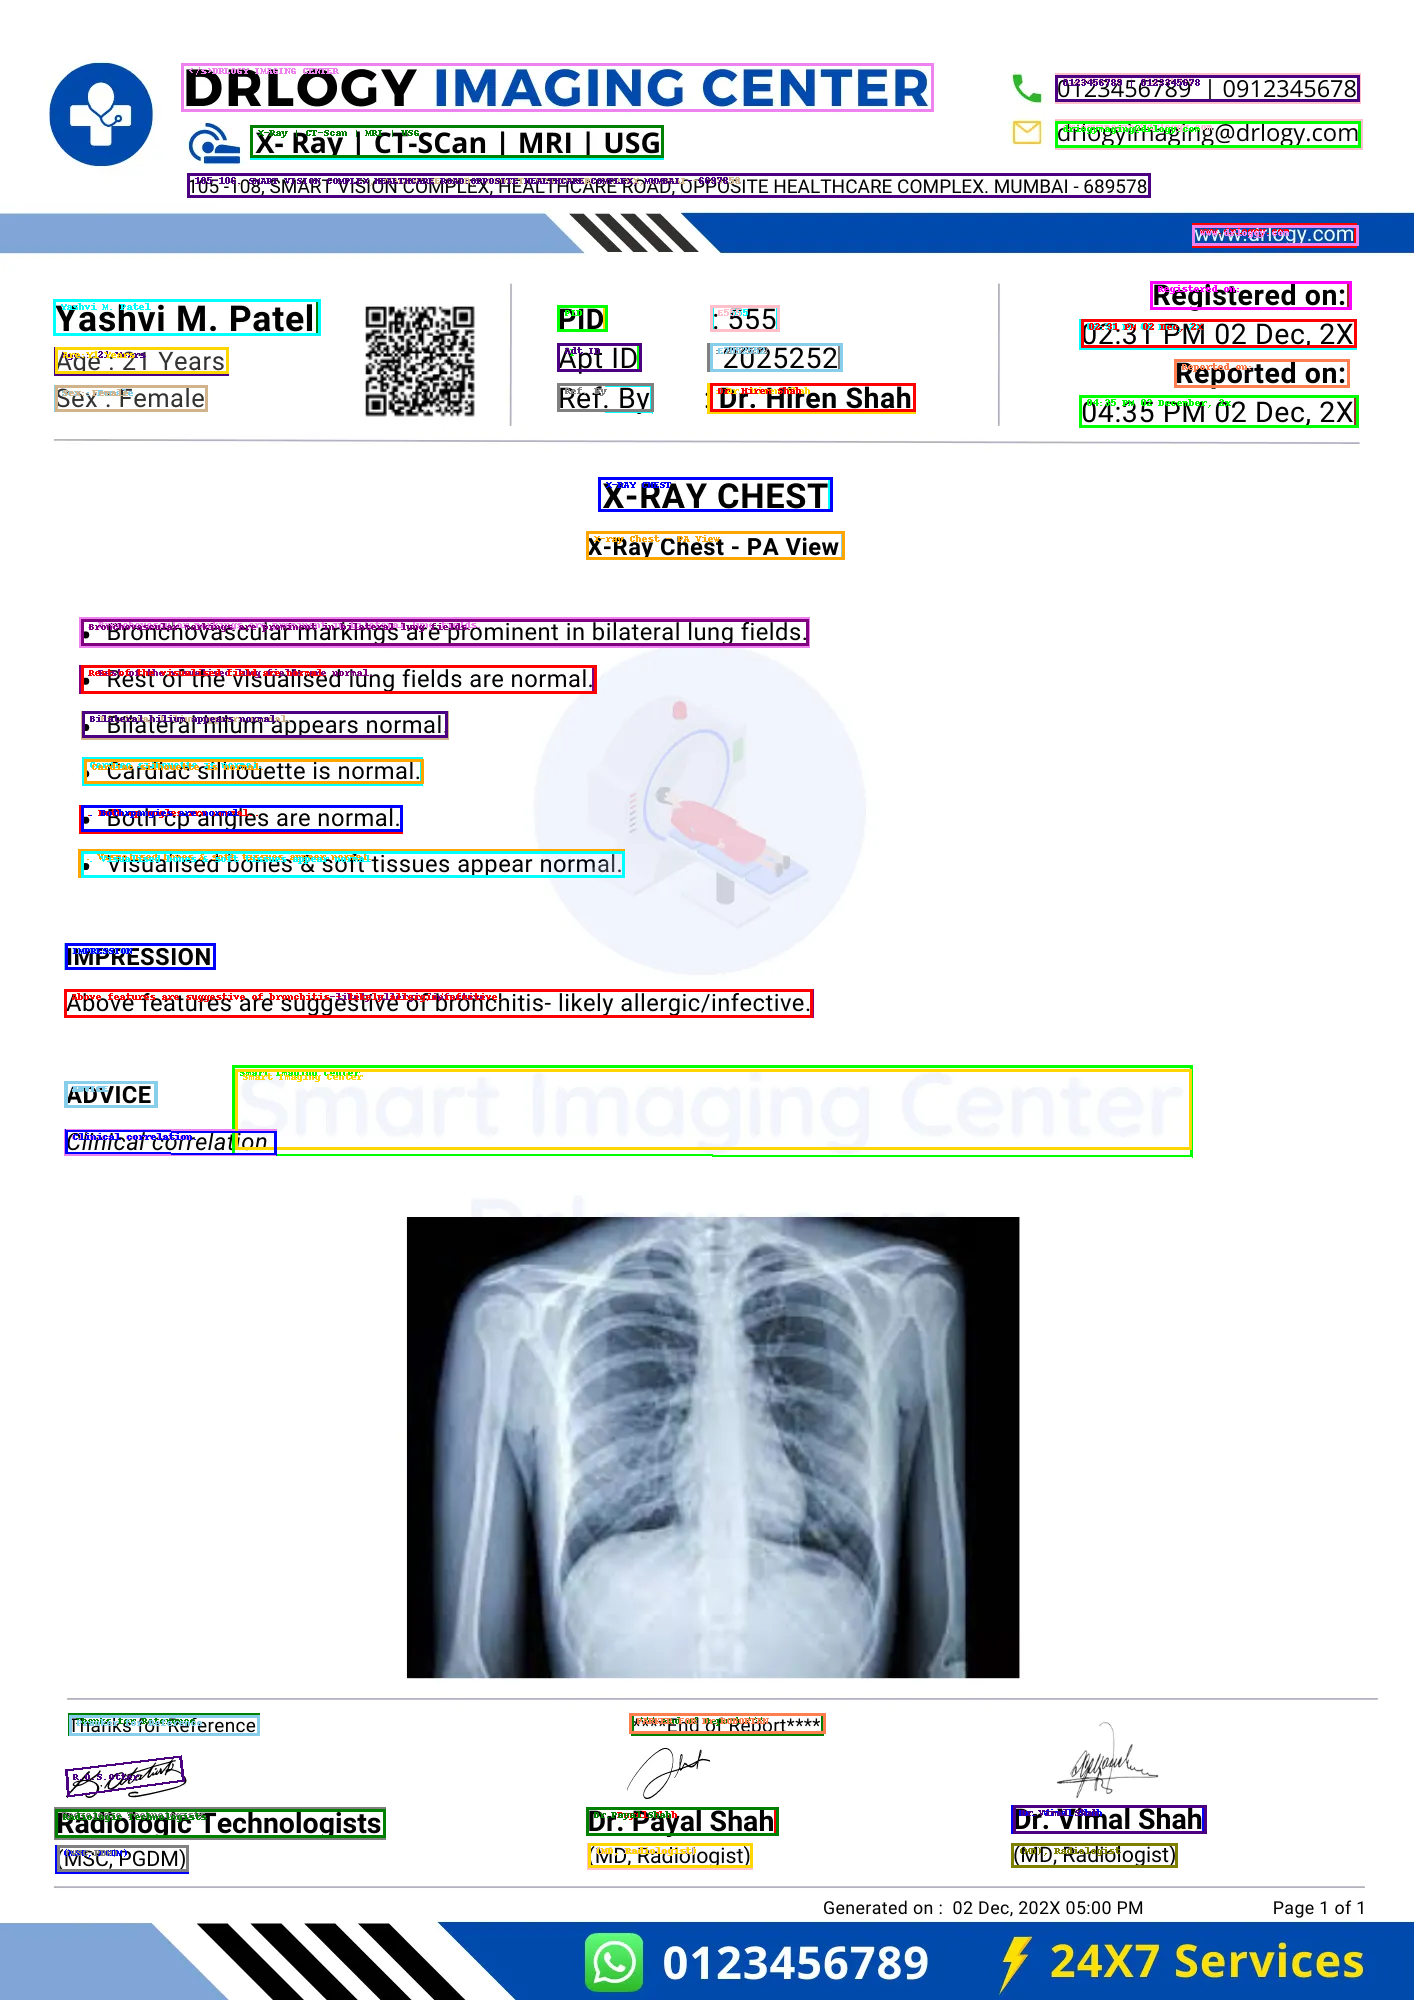

In [20]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt,image)
print(results)
output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])

## Fine Tuning

In [21]:
import torch
from PIL import Image
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoProcessor, get_scheduler
from tqdm import tqdm
import numpy as np
from bitsandbytes.optim import AdamW

In [22]:
model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={'use_reentrant':True})
for param in model.vision_tower.parameters():
    param.is_trainable = False

In [23]:
data = load_dataset("derek-thomas/ScienceQA")

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [24]:
class MMInstructDataset(Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<MMCHAT>"+example['question']+"\n\nAnswer:\n"
        choices = example['choices']
        answer = example['choices'][int(example['answer'])]
        if example['image'] is not None:
            image = example['image'].convert("RGB")
        else:
            zz = np.random.rand(50,50)
            image = Image.fromarray(zz).convert("RGB")
        return question, answer, image

In [25]:
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to("cuda")
    return inputs, answers

In [26]:
train_dataset = MMInstructDataset(data['train'])
val_dataset = MMInstructDataset(data['validation'])

batch_size = 1
gradient_accumulation_steps = 8
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          collate_fn=collate_fn, num_workers=num_workers)

In [27]:
torch.cuda.empty_cache()

In [28]:
optimizer = AdamW(model.parameters(), lr=1e-6, optim_bits = 8, is_paged=True)

epochs = 1
num_training_steps = epochs * len(train_loader)

lr_scheduler = get_scheduler(name="linear", optimizer=optimizer,
                              num_warmup_steps=0, num_training_steps=num_training_steps,)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    i = -1
    for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        i += 1
        input_ids = inputs["input_ids"]
        pixel_values = inputs["pixel_values"]
        labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to("cuda")
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss/gradient_accumulation_steps
        loss.backward()
        if i % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
            inputs, answers = batch
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to("cuda")
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

        print(val_loss / len(val_loader))

Training Epoch 1/1: 100%|██████████| 12726/12726 [6:50:41<00:00,  1.94s/it]  


Average Training Loss: 0.03458764450692736


Validation Epoch 1/1: 100%|██████████| 4241/4241 [45:41<00:00,  1.55it/s]

1.9027074766317873


In [71]:
out_dir = "/kaggle/working/florence_multimodal_finetuned/"

model.save_pretrained(out_dir)

In [72]:
import zipfile
import os

def compress_large_folder(folder_path, output_filename):
    with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED, allowZip64=True) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, arcname=os.path.relpath(file_path, folder_path))

# Example usage
compress_large_folder(out_dir, '/kaggle/working/florence_multimodal_finetuned.zip')


[Here are the tasks Florence-2 could perform:](https://huggingface.co/microsoft/Florence-2-large-ft#caption)

**Caption**  
`prompt = "<CAPTION>"`  
`run_example(prompt)`

**Detailed Caption**  
`prompt = "<DETAILED_CAPTION>"`  
`run_example(prompt)`

**More Detailed Caption**  
`prompt = "<MORE_DETAILED_CAPTION>"`  
`run_example(prompt)`

**Caption to Phrase Grounding**  
Requires additional text input, outputs bounding boxes and labels.  
`task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"`  
`results = run_example(task_prompt, text_input="A green car parked in front of a yellow building.")`

**Object Detection**  
Outputs bounding boxes and labels.  
`prompt = "<OD>"`  
`run_example(prompt)`

**Dense Region Caption**  
Outputs bounding boxes and labels.  
`prompt = "<DENSE_REGION_CAPTION>"`  
`run_example(prompt)`

**Region Proposal**  
Outputs bounding boxes.  
`prompt = "<REGION_PROPOSAL>"`  
`run_example(prompt)`

**OCR**  
`prompt = "<OCR>"`  
`run_example(prompt)`

**OCR with Region**  
Outputs quadrilateral bounding boxes and labels.  
`prompt = "<OCR_WITH_REGION>"`  
`run_example(prompt)`


In [93]:
def ocr_gen(image_path=local_image_path, task_prompt=task_prompt):
    image = Image.open(image_path)
    task_prompt = task_prompt
    results = run_example(task_prompt,image)
    print(results)
    try:
        output_image = copy.deepcopy(image)
        draw_ocr_bboxes(output_image, results[task_prompt])
    except:
        return image

{'<REGION_PROPOSAL>': {'bboxes': [[0.7070000171661377, 1.0, 1411.8790283203125, 1997.0]], 'labels': ['']}}


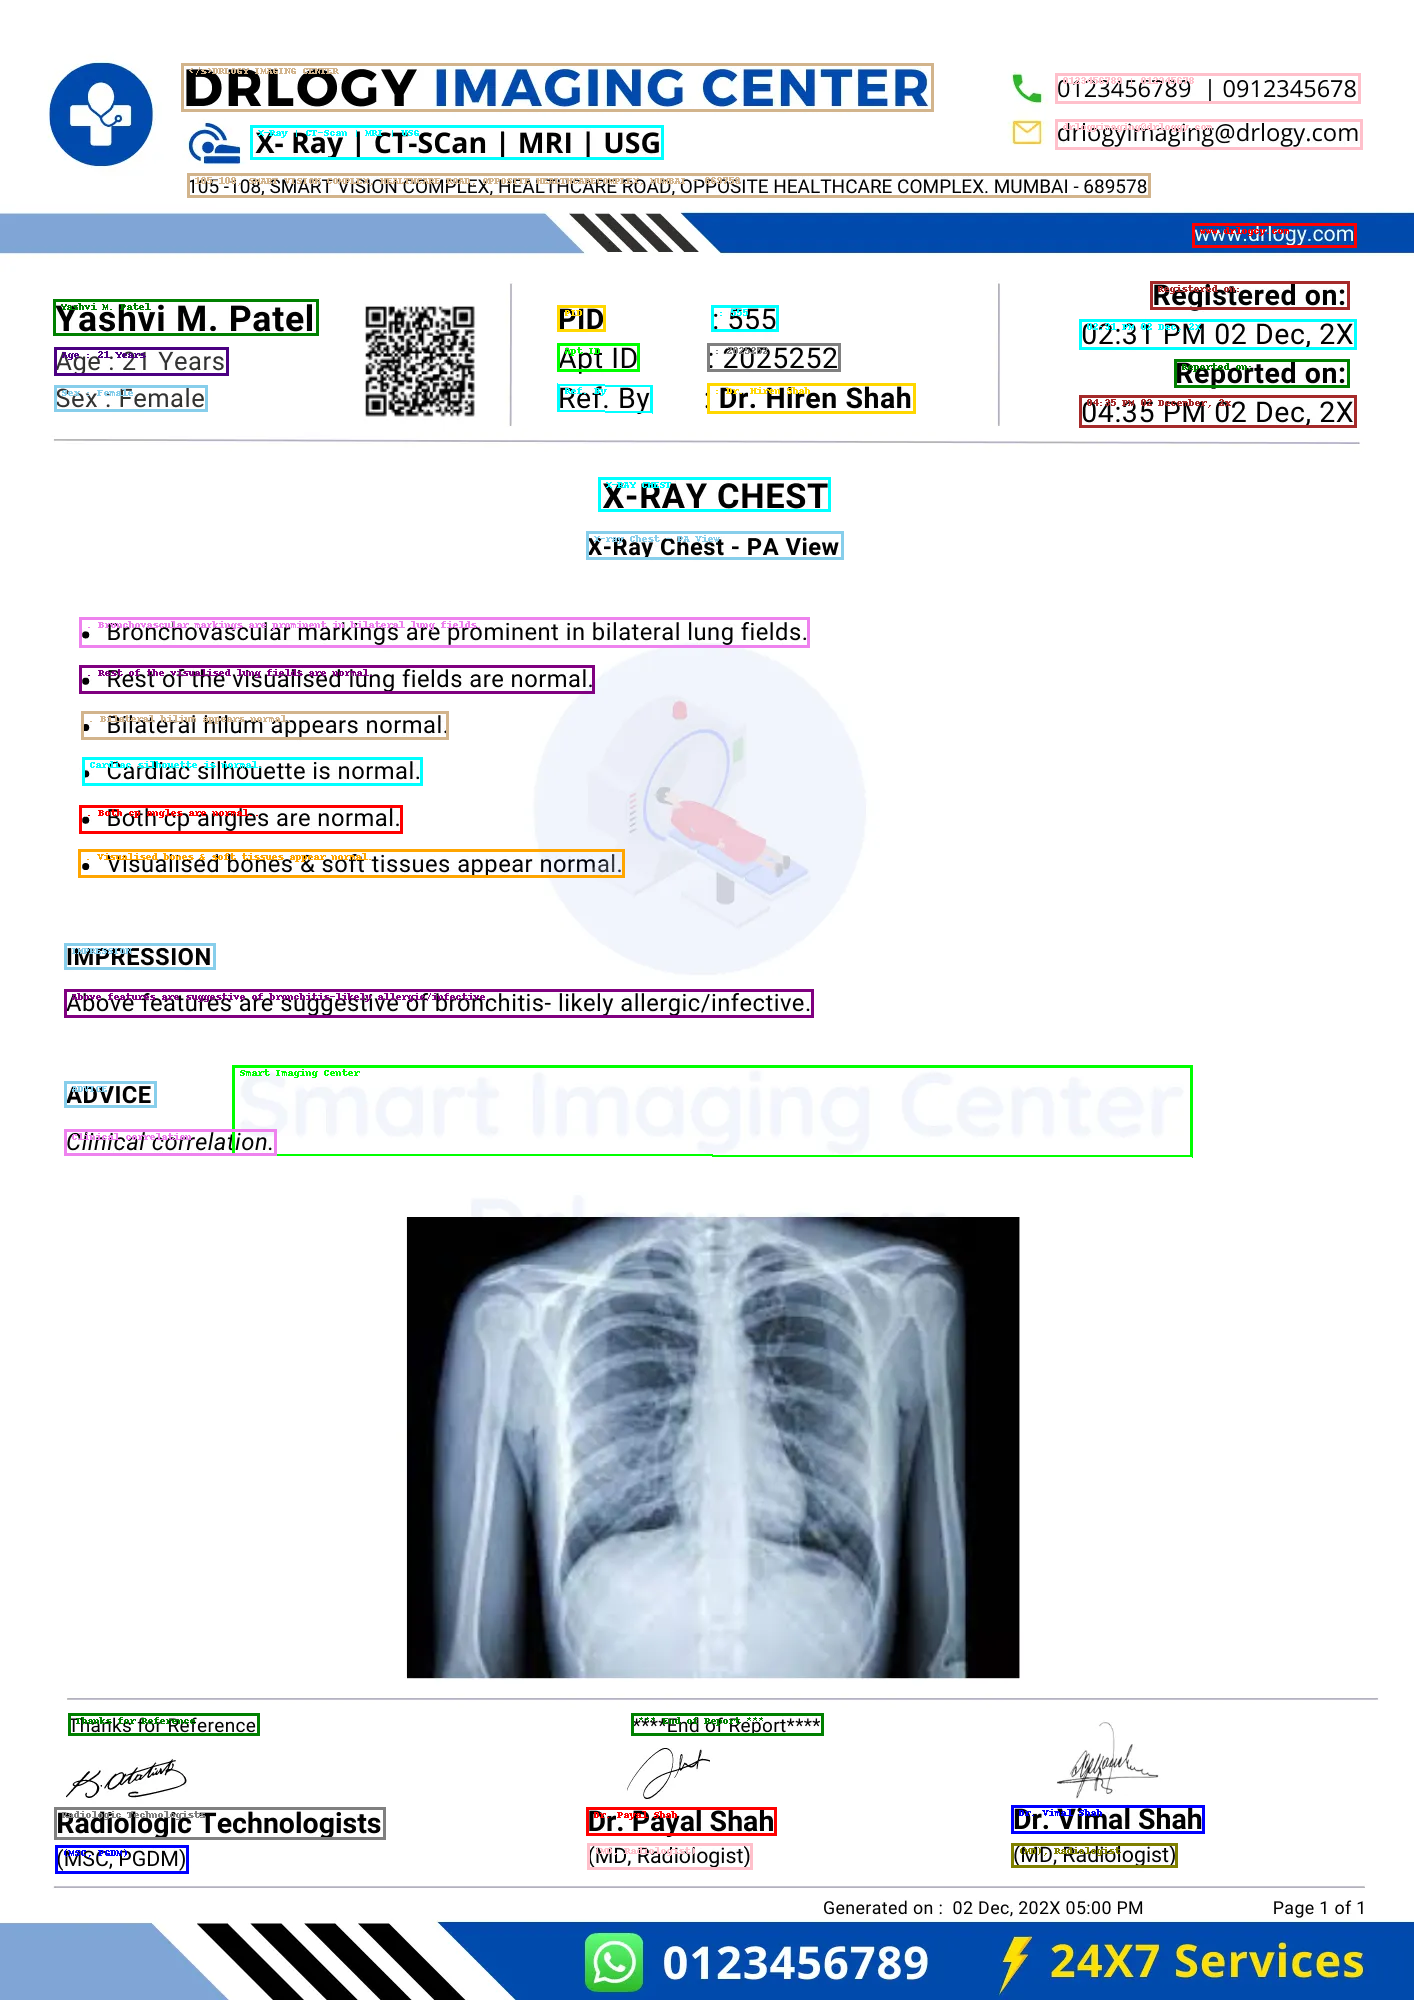

In [96]:
local_image_path = "/kaggle/input/images/radiolog report.jpg"
task_prompt = "<REGION_PROPOSAL>"

ocr_gen(local_image_path, task_prompt)

In [65]:
results

{'<CAPTION>': "a flyer for a medical clinic with a picture of a man's torso"}

prompt is : <CAPTION>
{'<CAPTION>': "a flyer for a medical clinic with a picture of a man's torso"}
---------------------------------------------------------------------------------------------------- 


prompt is : <DETAILED_CAPTION>
{'<DETAILED_CAPTION>': 'The image shows a poster with an x-ray image of a man\'s torso, along with text, a barcode, and a logo. The text reads "Dr. Hireen Shah, MD".'}
---------------------------------------------------------------------------------------------------- 


prompt is : <MORE_DETAILED_CAPTION>
{'<MORE_DETAILED_CAPTION>': 'The image is an X-ray of a patient\'s chest. The image is a close-up of the rib cage, which is visible in the center of the image. The rib cage is located on the right side of the chest and is surrounded by a white background.\n\nOn the top left corner, there is a barcode and the logo of Dr. Yashvi M. Patel, a medical professional. On the top right corner, it reads "X-ray Chest". Below the barcode, there are two buttons - "R

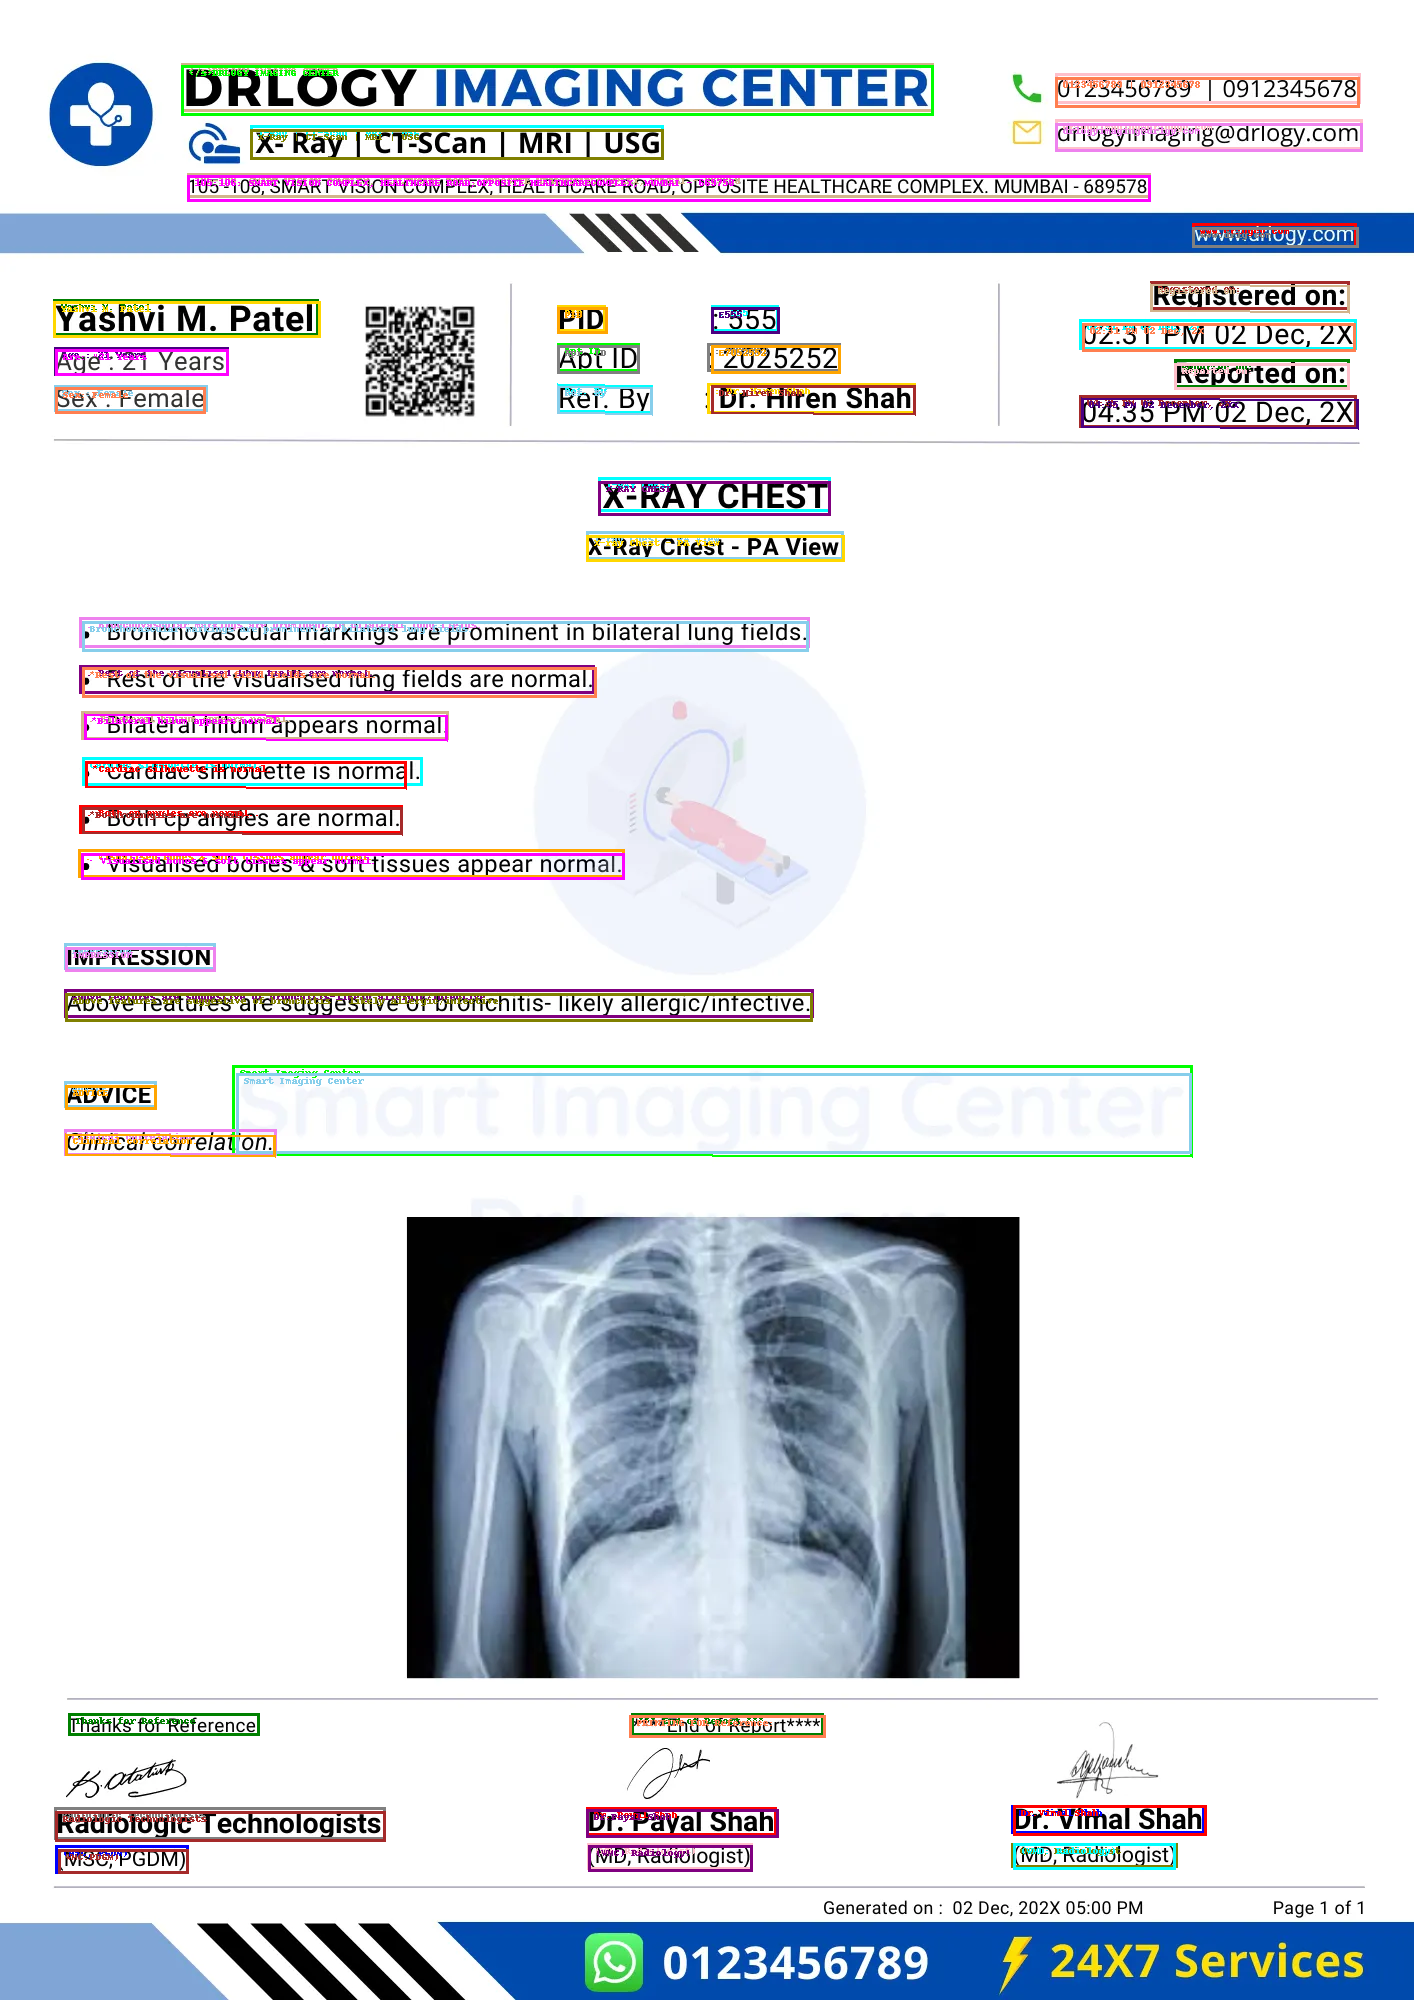

---------------------------------------------------------------------------------------------------- 




In [97]:
prompts = [
    "<CAPTION>",
    "<DETAILED_CAPTION>",
    "<MORE_DETAILED_CAPTION>",
    "<CAPTION_TO_PHRASE_GROUNDING>",
    "<OD>",
    "<DENSE_REGION_CAPTION>",
    "<REGION_PROPOSAL>",
    "<OCR>",
    "<OCR_WITH_REGION>"
]

for prompt in prompts:
    print(f"prompt is : {prompt}")
    results = run_example(prompt,image)
    print(results)
    try:
        output_image = copy.deepcopy(image)
        draw_ocr_bboxes(output_image, results[prompt])
    except:
        pass
    print("-"*100, "\n\n")